# Task1: Construction of swimmer

### Task 1.0: Initisalization of RL paramenters

RL can train 10 paramenters

$$K_1 \cdots K_5,B_1 \cdots B_5,\phi,\tau_{tail}$$

$$K_0=K_6=B_0=B_6=0$$

Their meaning will be apparant in the following sections.

We first randomly initiased them

In [218]:
import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

num_RL_curvature=4
K_RL=0.3-np.random.rand(num_RL_curvature+2)*0.6
B_RL=0.1-np.random.rand(num_RL_curvature+2)*0.2
Phase_shift=0
tau_tail=1
K_RL[0]=K_RL[-1]=0
B_RL[0]=B_RL[-1]=0

# Task 1.1: Build the class of swimmer

In [534]:
import numpy as np
from scipy.integrate import solve_ivp

from scipy.integrate import cumtrapz
import matplotlib.pylab as plt

# Define the parameters as regular Python function:
class swimmer:
    def __init__(self, K_RL,B_RL,Phase_shift,tau_tail):
        self.K_RL =  K_RL
        self.B_RL = B_RL
        self.Phase_shift = Phase_shift
        self.tau_tail = tau_tail

        self.L=10
        self.time_Interval=100
        self.space_interval=100
        self.y_interval=5
        self.T_prop=1/1.7
        self.T_prep=1-self.T_prop

        self.midline_coor=np.zeros((2,self.time_Interval,self.space_interval))
        self.body_coor=np.zeros((2,self.time_Interval,self.space_interval,2*self.y_interval+1))
        self.width_coor=np.zeros((2,self.time_Interval,2*self.space_interval))
        self.width_length=self.w()

        self.midline_vec=np.zeros((2,self.time_Interval,self.space_interval))
        self.body_vec=np.zeros((2,self.time_Interval,self.space_interval,2*self.y_interval+1))

## Task 1.2: Build the width function

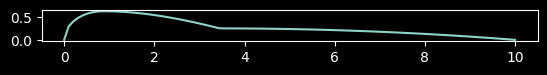

In [537]:
def w(self):
    def width(s):
        s_b=0.0862*self.L
        s_t=0.3448*self.L
        w_h=0.0635*self.L
        w_t=0.0254*self.L
        if 0 <=s and s<s_b:
            return w_h*np.sqrt(1-((s_b-s)/s_b)**2)
        elif s_b<=s and s<s_t:
            return (-2*(w_t-w_h)-w_t*(s_t-s_b))*((s-s_b)/(s_t-s_b))**3+\
                    (3*(w_t-w_h)+w_t*(s_t-s_b))*((s-s_b)/(s_t-s_b))**2+w_h
        elif s_t<=s and s<=self.L:
            return w_t-w_t*((s-s_t)/(self.L-s_t))**2
    vwidth = np.vectorize(width)
    return vwidth(np.linspace(0,self.L,self.space_interval))
swimmer.w=w
fish1=swimmer(K_RL,B_RL,Phase_shift,tau_tail)
plt.figure();
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.plot(np.linspace(0,fish1.L,fish1.space_interval),fish1.width_length)

## Task 1.3: Build the head reference frame

C:\Users\User\AppData\Local\Temp\ipykernel_24100\3615944991.py:62: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  coords = cumtrapz(T, x=s)
C:\Users\User\AppData\Local\Temp\ipykernel_24100\3615944991.py:63: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  midline_vec=cumtrapz(T_t, x=s)


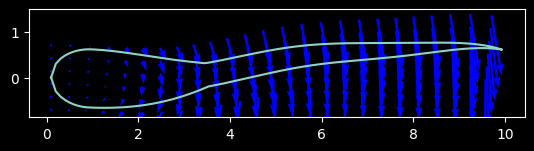

In [569]:
def head_ref(self,time_frame):
    time=time_frame/self.time_Interval*self.T_prop
    def tar(s):
        return s/self.L*self.tau_tail
    def K(s):
        K_inter = CubicSpline(np.arange(self.K_RL.shape[0]),K_RL)
        return K_inter(s/self.L*self.K_RL.shape[0])
    def B(s):
        B_inter = CubicSpline(np.arange(self.B_RL.shape[0]),B_RL)
        return B_inter(s/self.L*self.B_RL.shape[0])
    def k(s):
        return B(s)+K(s)*np.sin(2*np.pi*(time/self.T_prop-tar(s))+self.Phase_shift)
    def dkdt(s):
        return B(s)+K(s)*2*np.pi/self.T_prop*np.cos(2*np.pi*(time/self.T_prop-tar(s))+self.Phase_shift)
    def t_f(s):
        return 0
    def dt_fdt(s):
        return 0

    # The equations: dz/dt = model(s, z):

    def model(s, z):
        global t
        T = z[:3]   # z is a (9, ) shaped array, the concatenation of T, N and B 
        N = z[3:6]
        B = z[6:9]
        T_t=z[9:12]
        N_t=z[12:15]
        B_t=z[15:18]

        dTds =            k(s) * N  
        dNds = -k(s) * T          + t_f(s) * B
        dBds =           -t_f(s)* N

        dT_tds =                        dkdt(s) * N +k(s)*N_t
        dN_tds = -dkdt(s) * T-k(s)*T_t                         + dt_fdt(s) * B+t_f(s)*B_t
        dB_tds =                        -dt_fdt(s)*N-t_f(s)*N_t

        return np.hstack([dTds, dNds, dBds,dT_tds,dN_tds,dB_tds])

    T0, N0, B0,T_t0,N_t0,B_t0 = [1, 0, 0], [0, 1, 0], [0, 0, 1], [0, 0, 0] , [0, 0, 0] , [0, 0, 0] 

    z0 = np.hstack([T0, N0, B0, T_t0, N_t0, B_t0])

    s_span = (0, self.L) # start and final "time"
    t_eval = np.linspace(*s_span,self.space_interval+1)  # define the number of point wanted in-between,
                                        # It is not necessary as the solver automatically
                                        # define the number of points.
                                        # It is used here to obtain a relatively correct 
                                        # integration of the coordinates, see the graph

    # Solve:
    sol = solve_ivp(model, s_span, z0, t_eval=t_eval, method='RK45')
    # >> The solver successfully reached the end of the integration interval.

    # Unpack the solution:
    T, N, B, T_t, N_t, B_t= np.split(sol.y, 6)  # another way to unpack the z array
    s = sol.t

    # Bonus: integration of the normal vector in order to get the coordinates
    #        to plot the curve  (there is certainly better way to do this)
    coords = cumtrapz(T, x=s)
    midline_vec=cumtrapz(T_t, x=s)
    self.midline_coor[:,time_frame,:]=coords[0:2, :]

    self.width_coor[0,time_frame,:self.space_interval]=coords[0, :]+N[0,:self.space_interval]*self.width_length
    self.width_coor[0,time_frame,self.space_interval:]=(coords[0, :]-N[0,:self.space_interval]*self.width_length)[::-1]
    self.width_coor[1,time_frame,:self.space_interval]=coords[1, :]+N[1,:self.space_interval]*self.width_length
    self.width_coor[1,time_frame,self.space_interval:]=(coords[1, :]-N[1,:self.space_interval]*self.width_length)[::-1]

    self.body_coor[:,time_frame,:,:]=np.tile(coords[0:2, :,None],(1,1,2*self.y_interval+1))+(N[0:2,:self.space_interval,None]*np.linspace(-0.07*self.L,0.07*self.L,2*self.y_interval+1))

    self.midline_vec[:,time_frame,:]=midline_vec[0:2, :]
    self.body_vec[:,time_frame,:,:]=np.tile(midline_vec[0:2, :,None],(1,1,2*self.y_interval+1))+(N_t[0:2,:self.space_interval,None]*np.linspace(-0.07*self.L,0.07*self.L,2*self.y_interval+1))

    
swimmer.head_ref=head_ref
fish1=swimmer(K_RL,B_RL,Phase_shift,tau_tail)
fish1.head_ref(1)
plt.figure();
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.plot(fish1.width_coor[0,1],fish1.width_coor[1,1])
plt.quiver(np.ravel(fish1.body_coor[0,1,::4,::2]),np.ravel(fish1.body_coor[1,1,::4,::2]),np.ravel(fish1.body_vec[0,1,::4,::2]),np.ravel(fish1.body_vec[1,1,::4,::2]), color='b', units='xy', scale=10)

## Task 1.4: Build the animation function

C:\Users\User\AppData\Local\Temp\ipykernel_24100\916768510.py:62: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  coords = cumtrapz(T, x=s)
C:\Users\User\AppData\Local\Temp\ipykernel_24100\916768510.py:63: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  midline_vec=cumtrapz(T_t, x=s)


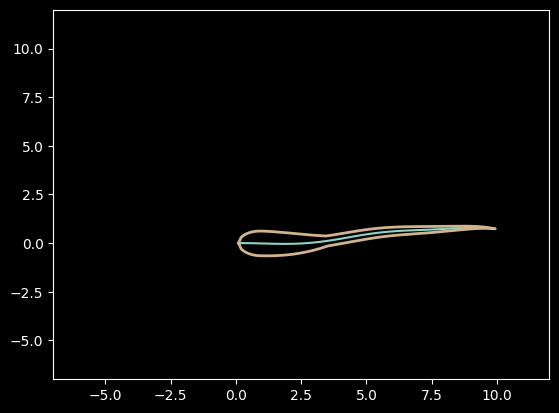

In [539]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.animation as animation

def animate_swim(self):
    fig, ax = plt.subplots()
    ax.set_xlim(( -7, 12))            
    ax.set_ylim((-7, 12))
    line, = ax.plot(self.midline_coor[0,0,:], self.midline_coor[1,0,:])
    line2, = ax.plot(self.width_coor[0,0,:], self.width_coor[1,0,:], 'tan', lw=2)

    def animate(i):
        line.set_xdata(self.midline_coor[0,i,:]) 
        line.set_ydata(self.midline_coor[1,i,:]) 
        line2.set_xdata(self.width_coor[0,i,:]) 
        line2.set_ydata(self.width_coor[1,i,:])  
        return (line,line2)


    ani = animation.FuncAnimation(
        fig, animate, interval=20, blit=True, frames=self.time_Interval)

    display(HTML(ani.to_jshtml()))

swimmer.animate_swim=animate_swim
fish1=swimmer(K_RL,B_RL,Phase_shift,tau_tail)
for i in range(fish1.time_Interval):
    fish1.head_ref(i)
fish1.animate_swim()

## Task 1.5: Find the particles that is within the contour of swimmer

C:\Users\User\AppData\Local\Temp\ipykernel_24100\3615944991.py:62: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  coords = cumtrapz(T, x=s)
C:\Users\User\AppData\Local\Temp\ipykernel_24100\3615944991.py:63: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  midline_vec=cumtrapz(T_t, x=s)


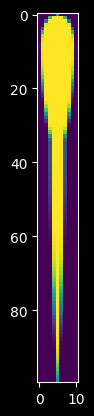

In [571]:
from scipy.misc import derivative
from numpy import linalg as LA
from scipy import integrate
def Xi_M(self,time):
    epsilon=0.01*self.L
    upper_half=self.body_coor[0,time,:,fish1.y_interval:]
    signed_distance=self.width_length[:,None]-LA.norm(self.body_coor[:,time,:,:]-self.midline_coor[:,time,:,None],axis=0)
    self.Xi_M_array=(signed_distance>epsilon)*1+(np.abs(signed_distance)<=epsilon)*1/2*(1+signed_distance/epsilon+1/np.pi*np.sin(np.pi*signed_distance/epsilon))
    
swimmer.Xi_M=Xi_M
fish1=swimmer(K_RL,B_RL,Phase_shift,tau_tail)
fish1.head_ref(1)
fish1.Xi_M(1)
plt.figure();
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.imshow(fish1.Xi_M_array)


## Task 1.6: Find position and velocity of CM relative to head

C:\Users\User\AppData\Local\Temp\ipykernel_24100\3615944991.py:62: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  coords = cumtrapz(T, x=s)
C:\Users\User\AppData\Local\Temp\ipykernel_24100\3615944991.py:63: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  midline_vec=cumtrapz(T_t, x=s)


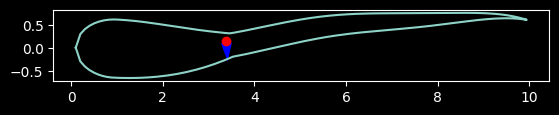

In [572]:
def Find_r_v_CM(self,time):
    M=np.sum(self.Xi_M_array)
    self.r_CM=np.sum(self.body_coor[:,time,:,:]*self.Xi_M_array,axis=(1,2))/M
    self.v_CM=np.sum(self.body_vec[:,time,:,:]*self.Xi_M_array,axis=(1,2))/M
swimmer.Find_r_v_CM=Find_r_v_CM
fish1=swimmer(K_RL,B_RL,Phase_shift,tau_tail)
time=1
fish1.head_ref(time)
fish1.Xi_M(time)
fish1.Find_r_v_CM(time)
plt.figure();
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.plot(fish1.width_coor[0,time],fish1.width_coor[1,time])
plt.plot(fish1.r_CM[0],fish1.r_CM[1],'ro')
plt.quiver(fish1.r_CM[0],fish1.r_CM[1],fish1.v_CM[0],fish1.v_CM[1], color='b', units='xy', scale=10)



## Task 1.7: Build CM frame

C:\Users\User\AppData\Local\Temp\ipykernel_24100\3615944991.py:62: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  coords = cumtrapz(T, x=s)
C:\Users\User\AppData\Local\Temp\ipykernel_24100\3615944991.py:63: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  midline_vec=cumtrapz(T_t, x=s)


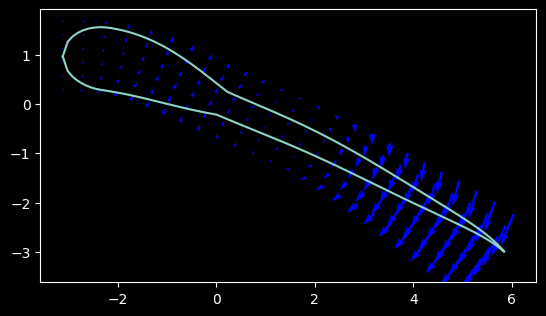

In [651]:
def CM_ref(self,time):
    self.body_coor[:,time,:]-=self.r_CM[:,None,None]
    self.midline_coor[:,time,:]-=self.r_CM[:,None]
    self.width_coor[:,time,:]-=self.r_CM[:,None]
    self.body_vec[:,time,:]-=self.v_CM[:,None,None]
swimmer.CM_ref=CM_ref
fish1=swimmer(K_RL,B_RL,Phase_shift,tau_tail)
time=40
fish1.head_ref(time)
fish1.Xi_M(time)
fish1.Find_r_v_CM(time)
fish1.CM_ref(time)
plt.figure();
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.plot(fish1.width_coor[0,time,:],fish1.width_coor[1,time,:])
plt.quiver(np.ravel(fish1.body_coor[0,time,::4,::2]),np.ravel(fish1.body_coor[1,time,::4,::2]),np.ravel(fish1.body_vec[0,time,::4,::2]),np.ravel(fish1.body_vec[1,time,::4,::2]), color='b', units='xy', scale=2)

C:\Users\User\AppData\Local\Temp\ipykernel_24100\3615944991.py:62: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  coords = cumtrapz(T, x=s)
C:\Users\User\AppData\Local\Temp\ipykernel_24100\3615944991.py:63: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  midline_vec=cumtrapz(T_t, x=s)


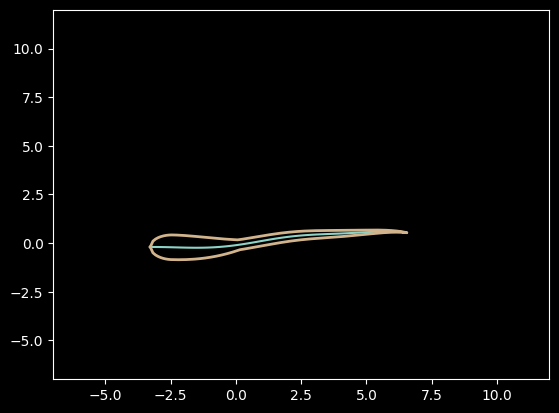

In [767]:
fish1=swimmer(K_RL,B_RL,Phase_shift,tau_tail)
for i in range(fish1.time_Interval):
    fish1.head_ref(i)
    fish1.Xi_M(i)
    fish1.Find_r_v_CM(i)
    fish1.CM_ref(i)
fish1.animate_swim()

## Task 1.8: Find the angular velocity

In [768]:
def Find_angular_velocity(self,time):
    angular_momentum=np.sum(np.cross(self.body_coor[:,time,:,:],self.Xi_M_array*self.body_vec[:,time,:,:],axis=0))
    moment_of_inertia=np.sum(self.Xi_M_array*np.sum(self.body_coor[:,time,:,:]**2,axis=0))
    self.angular_velocity=angular_momentum/moment_of_inertia
swimmer.Find_angular_velocity=Find_angular_velocity
fish1=swimmer(K_RL,B_RL,Phase_shift,tau_tail)
time=20
fish1.head_ref(time)
fish1.Xi_M(time)
fish1.Find_r_v_CM(time)
fish1.CM_ref(time)
fish1.Find_angular_velocity(time)
print(fish1.angular_velocity)

-3.0381322445517873


C:\Users\User\AppData\Local\Temp\ipykernel_24100\3615944991.py:62: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  coords = cumtrapz(T, x=s)
C:\Users\User\AppData\Local\Temp\ipykernel_24100\3615944991.py:63: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  midline_vec=cumtrapz(T_t, x=s)


## Task 1.9: Position correction to ensure no net angular momentum

C:\Users\User\AppData\Local\Temp\ipykernel_24100\3615944991.py:62: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  coords = cumtrapz(T, x=s)
C:\Users\User\AppData\Local\Temp\ipykernel_24100\3615944991.py:63: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  midline_vec=cumtrapz(T_t, x=s)


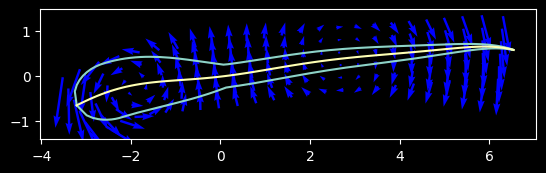

In [860]:
def remove_net_angular_velocity(self):
    omega=np.zeros(self.time_Interval)
    theta=np.zeros(self.time_Interval)
    for i in range(self.time_Interval):
        self.head_ref(i)
        self.Xi_M(i)
        self.Find_r_v_CM(i)
        self.CM_ref(i)
        self.Find_angular_velocity(i)
        omega[i]=fish1.angular_velocity
        if i==0:
            theta[i]=0
        else:
            theta[i]=theta[i-1]+(omega[i]+omega[i-1])/2*fish1.T_prop/fish1.time_Interval
    def Rotational_matrix(theta):
        return np.array([[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]])
    for time in range(fish1.time_Interval):
        a=np.concatenate((fish1.body_coor[:,time,:,:],np.zeros((1,fish1.body_coor.shape[2],fish1.body_coor.shape[3]))),axis=0)
        self.body_vec[:,time,:,:]-=np.cross(np.array([0,0,omega[time]]),a,axisb=0,axisc=0)[0:2,:,:]

        self.width_coor[:,time,:]=np.dot(self.width_coor[:,time,:].T,Rotational_matrix(theta[time])).T
        self.midline_coor[:,time,:]=np.dot(self.midline_coor[:,time,:].T,Rotational_matrix(theta[time])).T
        self.body_coor[:,time,:,:]=np.dot(self.body_coor[:,time,:,:].transpose(1,2,0),Rotational_matrix(theta[time])).transpose(2,0,1)
        self.body_vec[:,time,:,:]=np.dot(self.body_vec[:,time,:,:].transpose(1,2,0),Rotational_matrix(theta[time])).transpose(2,0,1)
swimmer.remove_net_angular_velocity=remove_net_angular_velocity
fish1=swimmer(K_RL,B_RL,Phase_shift,tau_tail)
fish1.remove_net_angular_velocity()
time=30
plt.figure();
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.plot(fish1.width_coor[0,time,:],fish1.width_coor[1,time,:])
plt.plot(fish1.midline_coor[0,time,:],fish1.midline_coor[1,time,:])
plt.quiver(np.ravel(fish1.body_coor[0,time,::4,::2]),np.ravel(fish1.body_coor[1,time,::4,::2]),np.ravel(fish1.body_vec[0,time,::4,::2]),np.ravel(fish1.body_vec[1,time,::4,::2]), color='b', units='xy', scale=3)



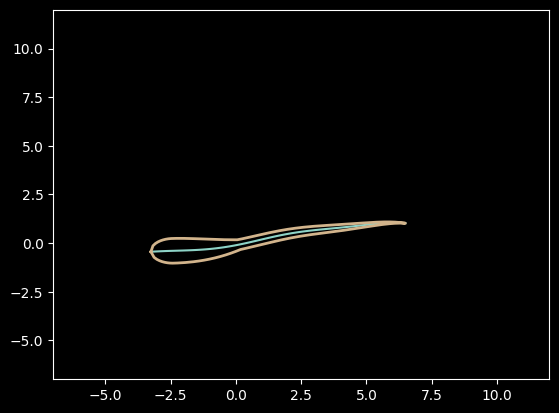

In [868]:
fish1.animate_swim()

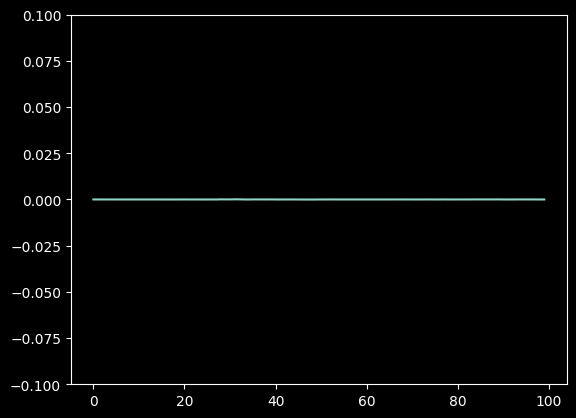

In [867]:
import matplotlib.pyplot as plt
omega=np.zeros(fish1.time_Interval)
theta=np.zeros(fish1.time_Interval)
for i in range(fish1.time_Interval):
    fish1.Find_angular_velocity(i)
    omega[i]=fish1.angular_velocity
plt.figure();
ax = plt.gca()
ax.set_ylim((-0.1,0.1))
plt.plot(omega)

## Task 1.10: Interpolate  Xi_M

C:\Users\User\AppData\Local\Temp\ipykernel_24100\3312491231.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


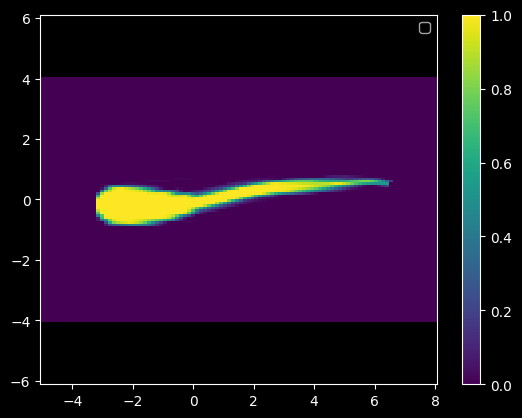

In [910]:
from scipy.interpolate import LinearNDInterpolator

import numpy as np

import matplotlib.pyplot as plt
def Xi_s(self,x_w,y_w,time):
    self.Xi_s=np.zeros((x_w.shape[0],y_w.shape[0]))

    x = np.ravel(fish1.body_coor[0,time,:,:])
    y = np.ravel(fish1.body_coor[1,time,:,:])
    z = np.ravel(fish1.Xi_M_array)

    minX_index=np.abs(x_w-min(x)).argmin()
    maxX_index=np.abs(x_w-max(x)).argmin()
    minY_index=np.abs(y_w-min(y)).argmin()
    maxY_index=np.abs(y_w-max(y)).argmin()
    X = x_w[minX_index:maxX_index]
    Y = y_w[minY_index:maxY_index]

    X, Y = np.meshgrid(X, Y)  # 2D grid for interpolation

    interp = LinearNDInterpolator(list(zip(x, y)), z)

    Z = np.nan_to_num(interp(X, Y))
    self.Xi_s[minY_index:maxY_index,minX_index:maxX_index]=Z
swimmer.Xi_s=Xi_s

Xi_s(fish1,np.linspace(-5,8,100),np.linspace(-4,4,100),1)

plt.pcolormesh(np.linspace(-5,8,100),np.linspace(-4,4,100),fish1.Xi_s, shading='auto')

plt.legend()

plt.colorbar()

plt.axis("equal")

plt.show()

## Task 1.11: interpolate deformation velocity

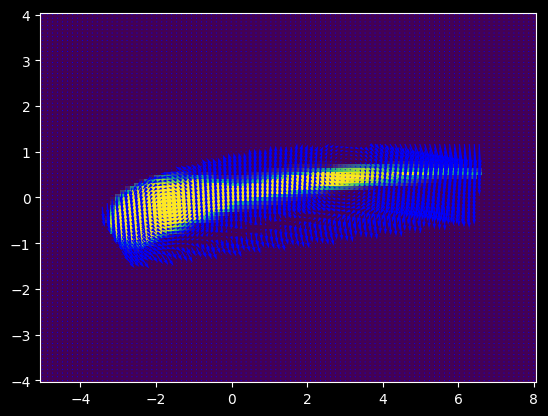

In [914]:
def Find_u_def(self,x_w,y_w,time):
    self.u_def=np.zeros((2,x_w.shape[0],y_w.shape[0]))

    x = np.ravel(fish1.body_coor[0,time,:,:])
    y = np.ravel(fish1.body_coor[1,time,:,:])

    v_realx = np.ravel(fish1.body_vec[0,time,:,:])
    v_realy = np.ravel(fish1.body_vec[1,time,:,:])

    minX_index=np.abs(x_w-min(x)).argmin()
    maxX_index=np.abs(x_w-max(x)).argmin()
    minY_index=np.abs(y_w-min(y)).argmin()
    maxY_index=np.abs(y_w-max(y)).argmin()
    X = x_w[minX_index:maxX_index]

    Y = y_w[minY_index:maxY_index]

    X, Y = np.meshgrid(X, Y)  # 2D grid for interpolation

    interp1 = LinearNDInterpolator(list(zip(x, y)), v_realx)
    interp2 = LinearNDInterpolator(list(zip(x, y)), v_realy)

    self.u_def[0,minY_index:maxY_index,minX_index:maxX_index]= np.nan_to_num(interp1(X, Y))
    self.u_def[1,minY_index:maxY_index,minX_index:maxX_index]= np.nan_to_num(interp2(X, Y))
swimmer.Find_u_def=Find_u_def
Find_u_def(fish1,np.linspace(-5,8,100),np.linspace(-4,4,100),40)
X,Y= np.meshgrid(np.linspace(-5,8,100),np.linspace(-4,4,100)) 

Xi_s(fish1,np.linspace(-5,8,100),np.linspace(-4,4,100),40)

plt.pcolormesh(np.linspace(-5,8,100),np.linspace(-4,4,100),fish1.Xi_s, shading='auto')

plt.quiver(X,Y,np.ravel(fish1.u_def[0]),np.ravel(fish1.u_def[1]), color='b', units='xy', scale=5)
